In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
from datetime import datetime
from pathlib import Path
import importlib
import time
import warnings
warnings.filterwarnings("ignore")  # Oculta todos los warnings

# Mis modulos
import ruta_vp
import transportista_cd
import files_management as fm
import send_reports_through_wssp as srtw
import print_management as pm

### Banner

In [6]:
# import pyfiglet
# print(pyfiglet.figlet_format("Rechazos WSSP"))

banner = r"""
 ____           _                         __        ______ ____  ____
|  _ \ ___  ___| |__   __ _ _______  ___  \ \      / / ___/ ___||  _ \
| |_) / _ \/ __| '_ \ / _` |_  / _ \/ __|  \ \ /\ / /\___ \___ \| |_) |
|  _ <  __/ (__| | | | (_| |/ / (_) \__ \   \ V  V /  ___) |__) |  __/
|_| \_\___|\___|_| |_|\__,_/___\___/|___/    \_/\_/  |____/____/|_|

          üí• AUTOMATIZADOR DE ENVIO DE REPORTES POR WSSP üí•
"""

print(banner, end='\n\n')
time.sleep(1)


 ____           _                         __        ______ ____  ____
|  _ \ ___  ___| |__   __ _ _______  ___  \ \      / / ___/ ___||  _ \
| |_) / _ \/ __| '_ \ / _` |_  / _ \/ __|  \ \ /\ / /\___ \___ \| |_) |
|  _ <  __/ (__| | | | (_| |/ / (_) \__ \   \ V  V /  ___) |__) |  __/
|_| \_\___|\___|_| |_|\__,_/___\___/|___/    \_/\_/  |____/____/|_|

          üí• AUTOMATIZADOR DE ENVIO DE REPORTES POR WSSP üí•




### Configuracion

In [21]:
# Diccionarios
parse_locaciones = {
    '06 AYA EL PEDREGAL': 'Pedregal',
    '38 AYA ATICO': 'Atico',
    '40 AYA CHALA': 'Chala',
    '88 AYA CAMANA': 'Camana'
}
months = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio',
    7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 
    11: 'Noviembre', 12: 'Diciembre'
}
transportista = {
    "name": "transportista",
    "file_name": "Cf_programadas_por_transportista.csv",    # Nombre del archivo local
    "date": "Fecha",
    "transportista": "C√≥digo de Transportista",
    "relevant_columns": [
        'Locaci√≥n', 
        'Transportista',
        'Fecha',
        'Carga Total CF',
        'Carga Pvta CF',
        'Rechazo CF',        
        'Orden de Carga',
        'C√≥digo de Transportista'
    ],
    "reports": [ # sobre 'Carga Pvta CF'
        'Transportista',
    ]
}
ruta = {
    "name": "ruta",
    "file_name": "Cf_rech_por_ruta.csv",                    # Nombre del archivo local
    "date": "D√≠a",
    "transportista": "C√≥digo Transportista",
    "relevant_columns": [
        'Locaci√≥n',
        'Ruta Troncal Din√°mico',
        'Motivo de anulaci√≥n',
        'D√≠a',
        'Venta Perdida CF',
        'Cliente',
        'Transportista',
        'Nombre Vendedor',
        'N√∫mero de orden de carga',
        'C√≥digo Transportista'
    ],
    "reports": [ # sobre 'Venta Perdida CF'
        'Motivo de anulaci√≥n',
        'Transportista',
        'Ruta Troncal Din√°mico',        
    ]
}

# Listas
locaciones = ['06 AYA EL PEDREGAL', '38 AYA ATICO', '40 AYA CHALA', '88 AYA CAMANA']

# Constantes
root_address = r'C:\Informacion\rechazos'
project_address = r"C:\Informacion\rechazos\Analisis\automatizacion_reporte_rechazos_wssp"

### Seleccionar documento a procesar

In [ ]:
importlib.reload(fm)
importlib.reload(ruta_vp)
importlib.reload(transportista_cd)

print("\nSeleccione fuente de datos:")
print("  [1] Ruta")
print("  [2] Transportista")
print("  [3] Terminar Proceso\n")

opcion_fuente = int(input("\n>> Opci√≥n (1 - 3): "))

if opcion_fuente == 1:
    # Procesamiento de archivo
    df = fm.file_processing(
        ruta,
        locaciones,
        root_address
    )
    # Parseo de fecha
    df = ruta_vp.parse_date(
        ruta, 
        df, 
    )
elif opcion_fuente == 2:
    # Procesamiento de archivo
    df = fm.file_processing(
        transportista,
        locaciones,
        root_address
    )
    # Parseo de fecha
    df = transportista_cd.parse_date(
        transportista, 
        df, 
    )
else:
    print("Proceso terminado.")
    exit()


Seleccione fuente de datos:
  [1] Ruta
  [2] Transportista



### Procesamiento de documentos

Filtrado por tiempo

In [39]:
importlib.reload(fm)

''' ESCOGER QUE TIPO DE ANALISIS HACER
(1) Por A√±o (Escoger el a√±o especifico) (Analisis de todo ese a√±o)
(2) Por Mes (Escoger el mes especifico) (Analisis de todo ese mes)
(3) Por D√≠a (Escoger el d√≠a especifico) (Analisis de todo ese d√≠a)
(4) Intervalo (Escoger fecha de inicio y fecha de fin especificas) (Analisis de todo el intervalo considerando las fechas ingresadas)
(5) Mayor igual que (Escoger fecha de inicio) (Analisis considerando esa fecha hasta el ultimo registro existente)
'''

# Seleccionar la opcion_tiempo de an√°lisis por tiempo
print("\nSelecciona filtro de tiempo:")
print("  [1] A√±o")
print("  [2] Mes")
print("  [3] D√≠a")
print("  [4] Intervalo")
print("  [5] Mayor o igual que\n")

time_option = int(input(">> Opci√≥n (1 - 5): "))

if opcion_fuente == 1:
    df, date = fm.get_specific_date(
        df,
        ruta,
        time_option
    )
else:
    df, date = fm.get_specific_date(
        df,
        transportista,
        time_option
    )


Selecciona filtro de tiempo:
  [1] A√±o
  [2] Mes
  [3] D√≠a
  [4] Intervalo
  [5] Mayor o igual que



Filtrado por locacion

In [ ]:
importlib.reload(fm)
importlib.reload(pm)

# Seleccionar locaciones
print("\nSelecciona filtro de locacion:")
print(f"  [1] Todas")
print(f"  [2] {locaciones[0]}")
print(f"  [3] {locaciones[1]}")
print(f"  [4] {locaciones[2]}")
print(f"  [5] {locaciones[3]}\n")

location_option = int(input("\n>> Opci√≥n (1 - 5): "))

df = fm.get_specific_location(df, location_option, locaciones)

pm.show_df(df)


Selecciona filtro de locacion:
  [1] Todas
  [2] 06 AYA EL PEDREGAL
  [3] 38 AYA ATICO
  [4] 40 AYA CHALA
  [5] 88 AYA CAMANA


üìä Resumen de DataFrame:
Locaci√≥n             object
Ruta Troncal Din√°mico object
Motivo de anulaci√≥n  object
D√≠a                  datetime64[ns]
Venta Perdida CF     float64
Cliente              object
Transportista        object
Nombre Vendedor      object
N√∫mero de orden de carga float64
C√≥digo Transportista float64

üî¢ Dimensi√≥n: 240 filas √ó 10 columnas
üíæ Memoria usada: 103.86 KB



### Reportes Ruta o Transportista

                Locaci√≥n Ruta Troncal Din√°mico Motivo de anulaci√≥n        D√≠a  \
8406  06 AYA EL PEDREGAL                     1             CERRADO 2025-06-02   
8407  06 AYA EL PEDREGAL                     2             CERRADO 2025-06-02   
8408  06 AYA EL PEDREGAL                     4             CERRADO 2025-06-02   
8409  06 AYA EL PEDREGAL                     4             CERRADO 2025-06-02   
8410  06 AYA EL PEDREGAL                     6             CERRADO 2025-06-02   

      Venta Perdida CF                        Cliente  \
8406               2.5  SANCHEZ HUAYNA GLORIA CICILIA   
8407               2.0  LUQUE AGUILAR SHIRLEY TATIANA   
8408               1.5              ACERO GOMEZ ELENA   
8409              10.0         MU√ëOZ DIAZ PABLO PEDRO   
8410               3.5     QUISPE DE ARAGON MAXIMIANA   

                         Transportista                     Nombre Vendedor  \
8406         ROBIN WILFREDO YUCRA SOTO  CARDENAS CHOQUECAJIA WHITNEY AWARD   
8407     

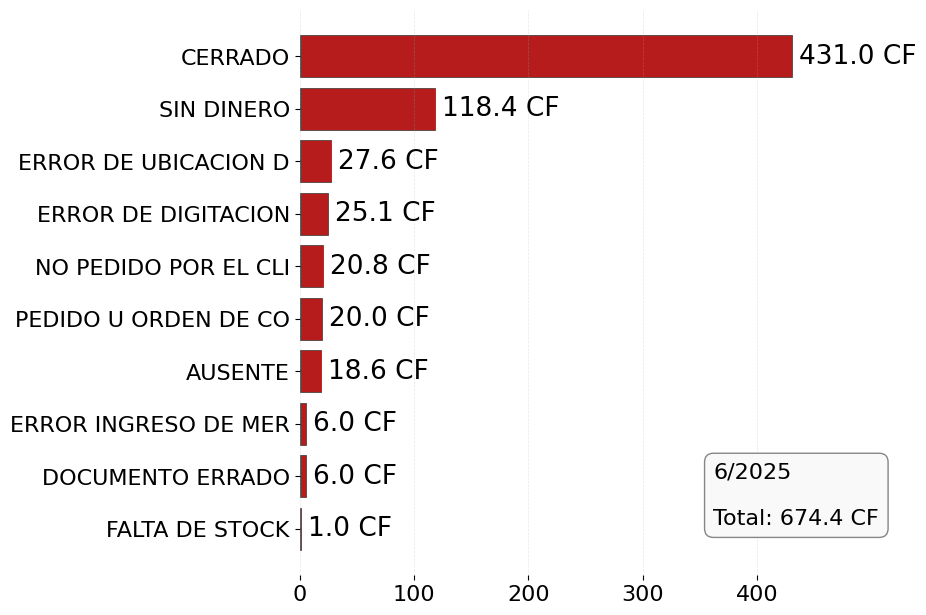

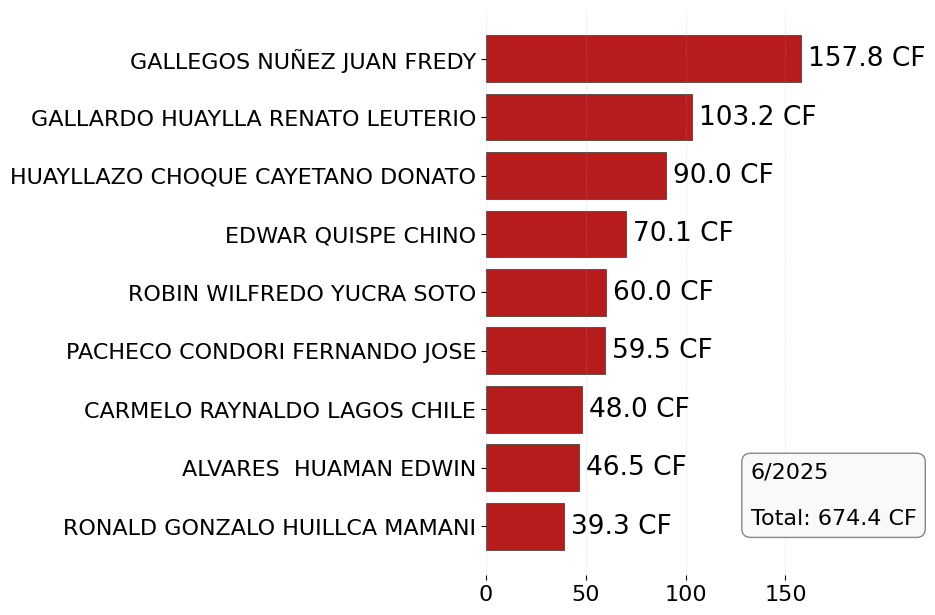

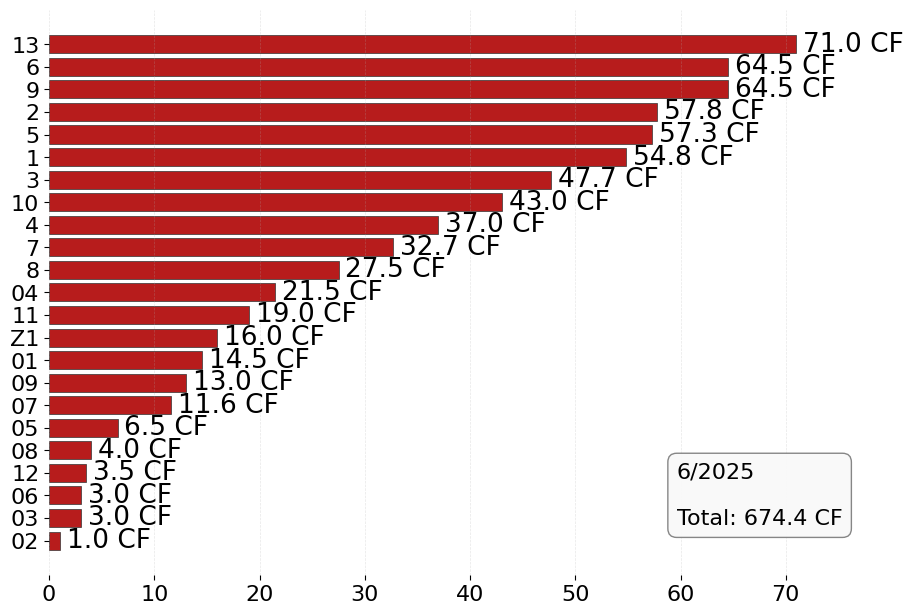

In [ ]:
importlib.reload(ruta_vp)
importlib.reload(transportista_cd)

if opcion_fuente == 1:
    ruta_vp.main(
        project_address,
        df,
        ruta,
        date
    )
    pm.show_document(ruta)
else:
    transportista_cd.main(
        project_address,
        df,
        transportista,
        date
    )
    pm.show_document(transportista)

### Envio de Reporte

In [ ]:
importlib.reload(srtw)

# Envio de reportes a grupo de wssp
def send_reports(group_option):
    WSSP_CONFIF = {
        'page_url': 'https://web.whatsapp.com',
        'group_names': ['PEDREGAL - DISTRIBUCI√ìN'] if group_option == 1 else ['GrupoPrueba - √≥n'],
    }

    srtw.main(project_address, WSSP_CONFIF)

# üîÅ Bucle de confirmaci√≥n
while True:
    # Seleccionar grupo de wssp
    print("\nSelecciona grupo de wssp:")
    print("  [1] Grupo Oficial")
    print("  [2] Grupo de Prueba")
    print("  [3] Terminar proceso")

    group_option = int(input("\n>> Opci√≥n (1 - 3): "))

    if group_option == 3 or group_option > 2:
        print("\n[‚úì] Proceso finalizado.\n")
        break  # salir del bucle
    else:        
        send_reports(group_option)

### Limpiar carpeta

In [ ]:
carpeta = Path(project_address)
#print(list(carpeta.glob('*.png')))

# Eliminar archivos .png
for imagen in carpeta.glob('*.png'):
    imagen.unlink()  # .unlink() elimina el archivo
    print(f'Eliminando: {imagen}')

[WindowsPath('c:/Informacion/rechazos/Analisis/automatizacion_reporte_rechazos_wssp/barh_Motivo de anulaci√≥n_Venta Perdida CF.png'), WindowsPath('c:/Informacion/rechazos/Analisis/automatizacion_reporte_rechazos_wssp/barh_Ruta Troncal Din√°mico_Venta Perdida CF.png'), WindowsPath('c:/Informacion/rechazos/Analisis/automatizacion_reporte_rechazos_wssp/barh_Transportista_Venta Perdida CF.png')]
Eliminado: c:\Informacion\rechazos\Analisis\automatizacion_reporte_rechazos_wssp\barh_Motivo de anulaci√≥n_Venta Perdida CF.png
Eliminado: c:\Informacion\rechazos\Analisis\automatizacion_reporte_rechazos_wssp\barh_Ruta Troncal Din√°mico_Venta Perdida CF.png
Eliminado: c:\Informacion\rechazos\Analisis\automatizacion_reporte_rechazos_wssp\barh_Transportista_Venta Perdida CF.png


### Export it as .py

In [2]:
import nbformat
from nbconvert import PythonExporter

# Cargar el notebook
notebook_path = "main.ipynb"
with open(notebook_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Eliminar la √∫ltima celda
nb['cells'] = nb['cells'][:-1]

# Convertir a script .py
exporter = PythonExporter()
codigo_python, _ = exporter.from_notebook_node(nb)

# Guardar el archivo .py
with open("main.py", "w", encoding="utf-8") as f:
    f.write(codigo_python)

print("‚úÖ Archivo .py creado sin la √∫ltima celda.")

‚úÖ Archivo .py creado sin la √∫ltima celda.
